# Introdução
Este notebook faz parte do trabalho de conclusão do curso (TCC) apresentado para obtenção do título de especialista no curso de Ciência de Dados e Big Data na PUC / Minas Gerais.


## Objetivo
Este notebook é auxiliar ao **analysis.ipynb**, e tem como objetivo gerar o arquivo:

>processed_listing_reviews_small.csv
- Dados: Polaridade (NLP) das avaliações no **reviews.csv**, indexadas pelo ID do anúncio.

## Fontes de Dados
### Esse script precisa das seguintes fontes de dados:

>reviews.csv

- Dados: Avaliações dos imóveis listados em Toronto, Ontario, na plataforma Airbnb em 08 de Fevereiro de 2021. Indexados pelo ID da avaliação.
- Fonte: Dados obtidos do site Insideairbnb.com.


# 0 - Importando Bibliotecas

In [29]:
#!pip3 install nltk
#!pip3 install wordcloud

In [20]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re 
import string

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [31]:
#Setting up nltk with vader lexicon
nltk.download('vader_lexicon')

# 1 - Leitura e Importação dos Dados de Entrada

## Definindo o PATH dos arquivos

In [19]:
# Arquivos obtidos de fontes externas
file_toronto_reviews = '../2-data/input/Toronto_2021-02-08/reviews.csv'

# Onde salvar os arquivos com dados gerados, para utilização no script principal
processed_files = '../2-data/generated/'

# Onde vamos salvar as figuras geradas, para utilização no relatório
final_figures = '../3-report/figures/'

In [11]:
df = pd.read_csv(file_toronto_reviews, index_col = 'id')
#df = pd.read_csv(file_toronto_reviews)

In [34]:
df.shape

(424060, 5)

In [12]:
## Basic Configs (.ipynb)
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', len(df.columns))
pd.set_option('display.width', 1000)

# 2 - Processamento e limpeza dos dados

In [13]:
print(df['comments'].isna().sum())

355


In [14]:
# Removendo valores N/A da coluna 'description', visto que esses não poderiam ter seu texto analisado

columnToProcess = 'comments'
df.dropna(subset = [columnToProcess],how='any',axis=0,inplace=True)

In [15]:
# As descrições em varios erros de importação e inconsisências que iriam atrapalhar no processamento.
# Esses vão ser removidos com esses filtros

importingArtifacts = lambda x: x.replace("<br />","").replace("<b>","").replace("</b>","").replace("<b","")
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punctuation = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

In [16]:
df[columnToProcess] = df[columnToProcess].map(importingArtifacts).map(alphanumeric).map(punctuation)

In [40]:
df.head(2)

,listing_id,date,reviewer_id,reviewer_name,comments
id,,,,,
38924112,1419,2015-07-19,11308465,Marcela,having the opportunity of arriving to alexandr...
44791978,1419,2015-08-29,9580285,Marco,we have no enough words to describe how beauty...


# 3 - Gerando a polaridade das avaliações e exportando

In [41]:
vectorizer = TfidfVectorizer(min_df=50, stop_words='english')
feature_matrix = vectorizer.fit_transform(df[columnToProcess])
print(feature_matrix.shape)

## Calcular o polarity_score das avaliações

In [ ]:
# Nota que o retorno é no formato {"neg" : ..., "neu" : ..., "pos" : ..., "compound" : ...}
# neu -> resultados neutros (-0.05 a 0.05), neg (<-0.05), pos (> 0.05)
# Aqui nós estamos interessados no compound, que é a combinação dos anteriores
vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

In [43]:
#Celula mais demorada pra rodar ~40 minutos
df['review_polarity'] = df[columnToProcess].map(vader_polarity_compound)

(423705, 6813)


In [51]:
df.head(5)

,listing_id,date,...,comments,review_polarity
id,,,,,
247436497,21785403,2018-03-28,...,patrick s home was absolutely amazing we wer...,0.9996
464008318,27525463,2019-06-04,...,my husband and i visited toronto on a somewhat...,0.9996
88149472,5521420,2016-07-23,...,it is easy to see why sandy has been designate...,0.9996
494036432,36478288,2019-07-23,...,if i were to summarize our experience staying ...,0.9996
417831801,13417473,2019-02-28,...,i was originally going to stay at lynn s place...,0.9995


In [53]:
## Removendo todas as colunas, exceto pela de nosso interesse (listing id, description, review_polarity)
#df = df[[columnToProcess,'', 'review_polarity']] 

# Ordenando por review_polarity
df=df.sort_values('review_polarity', ascending=False)

#Salvando no arquivo final
df.to_csv(processed_files + 'processed_listing_reviews_complete.csv')

# 4 - Análise dos Dados

In [54]:
## Ordenando por description_polarity e agrupando por listing_id. Isso remove múltiplas 
## linhas, simplifica por ID único e reduz significativamente o tamanho de arquivo.

df.groupby('listing_id')['review_polarity'].mean().sort_values(ascending=False).to_csv(processed_files + 'processed_listing_reviews_small.csv')
#df[['review_polarity']].to_csv(processed_files + 'processed_listing_reviews_small.csv')


In [55]:
df.head(2)

,listing_id,date,...,comments,review_polarity
id,,,,,
247436497,21785403,2018-03-28,...,patrick s home was absolutely amazing we wer...,0.9996
494036432,36478288,2019-07-23,...,if i were to summarize our experience staying ...,0.9996


In [57]:
## OBS: Para bypassar o processamento pesado, uma alternativa é já carregar o arquivo pós-processado, em uma execução anterior
df_processed = pd.read_csv(processed_files + 'processed_listing_reviews_complete.csv', index_col="id")
#df_processed = pd.read_csv(processed_files + 'processed_listing_reviews_small.csv', index_col="id")

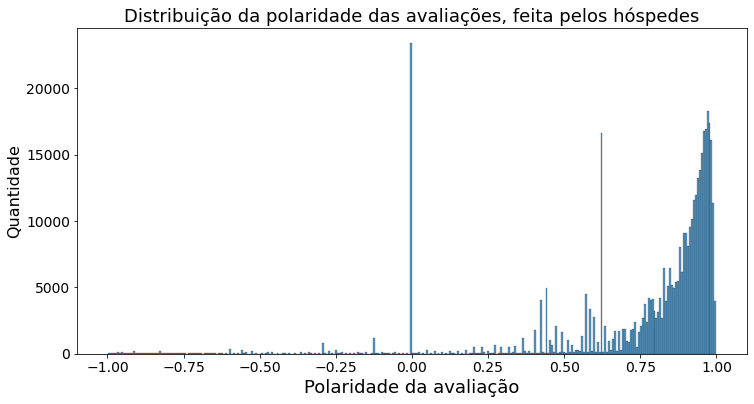

In [59]:
plt.figure(figsize=(12,6))
sns.histplot(df_processed['review_polarity'])
plt.title('Distribuição da polaridade das avaliações, feita pelos hóspedes',fontsize=18)
plt.xlabel('Polaridade da avaliação',fontsize=18)
plt.ylabel('Quantidade',fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

## Analisando as duas piores e as duas melhores avaliações, conforme polaridade

In [29]:
#DEBUG: Buscar por ID individual, antes do processamento.
#raw_df = pd.read_csv(file_toronto_reviews, index_col = 'id')
#pd.set_option('display.max_colwidth', None)
#raw_df.filter(like='247436497', axis=0).comments

In [64]:
pd.set_option('display.max_colwidth', None)

# Segunda pior avaliação
print(df_processed.iloc[[-2]])



           listing_id        date  ...  \
id                                 ...   
540026446    34862782  2019-10-02  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [65]:
# Melhor avaliação
print(df_processed.iloc[[0]])
#print(df_n.loc[df_n.index==26662976].description)

           listing_id        date  ...  \
id                                 ...   
247436497    21785403  2018-03-28  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [66]:
# Segunda Melhor descrição
print(df_processed.iloc[[1]])

           listing_id        date  ...  \
id                                 ...   
494036432    36478288  2019-07-23  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Gerando uma núvem de palavras com as descrições mais positivas

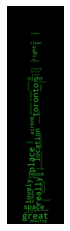

In [83]:
mask = np.array(Image.open("./masks/cn_tower_toronto_mask.png"))
positive_text = str(df_processed[lambda x: x['review_polarity'] >= 0.5])

# adding movie script specific stopwords
stopwords = set(STOPWORDS)
stopwords.add("int")
stopwords.add("ext")
stopwords.add("id")
stopwords.add("due")
stopwords.add("msg")
stopwords.add("couldn")
stopwords.add("bedroom")
stopwords.add("studio")
stopwords.add("apartment")
stopwords.add("condo")
stopwords.add("den")
stopwords.add("plus")
stopwords.add("review_polarity")

wc = WordCloud(background_color="black",max_words=2000, mask=mask, stopwords=stopwords, color_func=lambda *args, **kwargs: (50, 205, 50), min_word_length=5, min_font_size=10, width=1000, height=1000, max_font_size=200).generate(positive_text)
wc.to_file(final_figures+'wordcloud_review_descriptions.png')

# store default colored image
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
